In [5]:
!pip install jupyterlab psycopg2-binary crate pandas

## 🔹 1. Setup Connections

In [ ]:
import psycopg2
from crate import client
import pandas as pd
import time
from dotenv import load_dotenv
import os

load_dotenv()
passwordDB = os.getenv("DB_PASSWORD")  

# PostgreSQL connection|
pg_conn = psycopg2.connect(
    dbname="test", user="postgres", password=passwordDB, host="localhost", port="5433"
)
pg_cursor = pg_conn.cursor()
print("Postgre Connection Status 200")

# CrateDB connection
crate_conn = client.connect("http://localhost:4200", username="crate")
crate_cursor = crate_conn.cursor()
print("Crate Connection Status 200")


Postgre Connection Status 200
Crate Connection Status 200


## 🔹 2. Define Your SQL Queries

In [39]:
queries = {
    "Top Customers by Spending": """
        SELECT customer_id, COUNT(*) AS total_orders, SUM(total_amount) AS total_spent
        FROM orders
        GROUP BY customer_id
        ORDER BY total_spent DESC
        LIMIT 10;
    """,

    "Category Revenue": """
        SELECT p.category_id,
               ROUND(SUM(oi.quantity * oi.unit_price)::NUMERIC, 2) AS revenue
        FROM order_items oi
        JOIN products p ON oi.product_id = p.id
        GROUP BY p.category_id
        ORDER BY revenue DESC
        LIMIT 10;
    """,

    "Monthly Order Volume": """
        SELECT DATE_TRUNC('month', order_date) AS month, COUNT(*) AS total_orders
        FROM orders
        GROUP BY month
        ORDER BY month;
    """,

    "Count of Expensive Order Items (unit_price > 500)": """
        SELECT COUNT(*) 
        FROM order_items 
        WHERE unit_price > 500;
    """,

    "Top Selling Products by Quantity": """
        SELECT product_id, SUM(quantity) AS total_sold
        FROM order_items
        GROUP BY product_id
        ORDER BY total_sold DESC
        LIMIT 10;
    """,

    "Customer Lifetime Summary": """
        SELECT customer_id,
               COUNT(*) AS total_orders,
               ROUND(SUM(total_amount)::NUMERIC, 2) AS total_spent,
               MAX(order_date) AS last_order_date
        FROM orders
        GROUP BY customer_id
        ORDER BY total_spent DESC
        LIMIT 20;
    """
}


## 🔹 3. Execute and Compare

In [40]:
results = []

for name, sql in queries.items():
    # PostgreSQL
    start_pg = time.time()
    pg_cursor.execute(sql)
    pg_data = pg_cursor.fetchall()
    pg_time = time.time() - start_pg

    # CrateDB
    start_crate = time.time()
    crate_cursor.execute(sql)
    crate_data = crate_cursor.fetchall()
    crate_time = time.time() - start_crate

    results.append({
        "Query": name,
        "PostgreSQL Time (s)": round(pg_time, 4),
        "CrateDB Time (s)": round(crate_time, 4),
        "Faster Engine": "CrateDB" if crate_time < pg_time else "PostgreSQL"
    })

pd.DataFrame(results)

,Query,PostgreSQL Time (s),CrateDB Time (s),Faster Engine
0,Top Customers by Spending,0.1351,0.0418,CrateDB
1,Category Revenue,0.2428,0.5193,PostgreSQL
2,Monthly Order Volume,0.0257,0.0084,CrateDB
3,Count of Expensive Order Items (unit_price > 500),0.0448,0.0050,CrateDB
4,Top Selling Products by Quantity,0.1675,0.0952,CrateDB
5,Customer Lifetime Summary,0.0899,0.0755,CrateDB


## 🔹 4. Optional: Visualize the Comparison

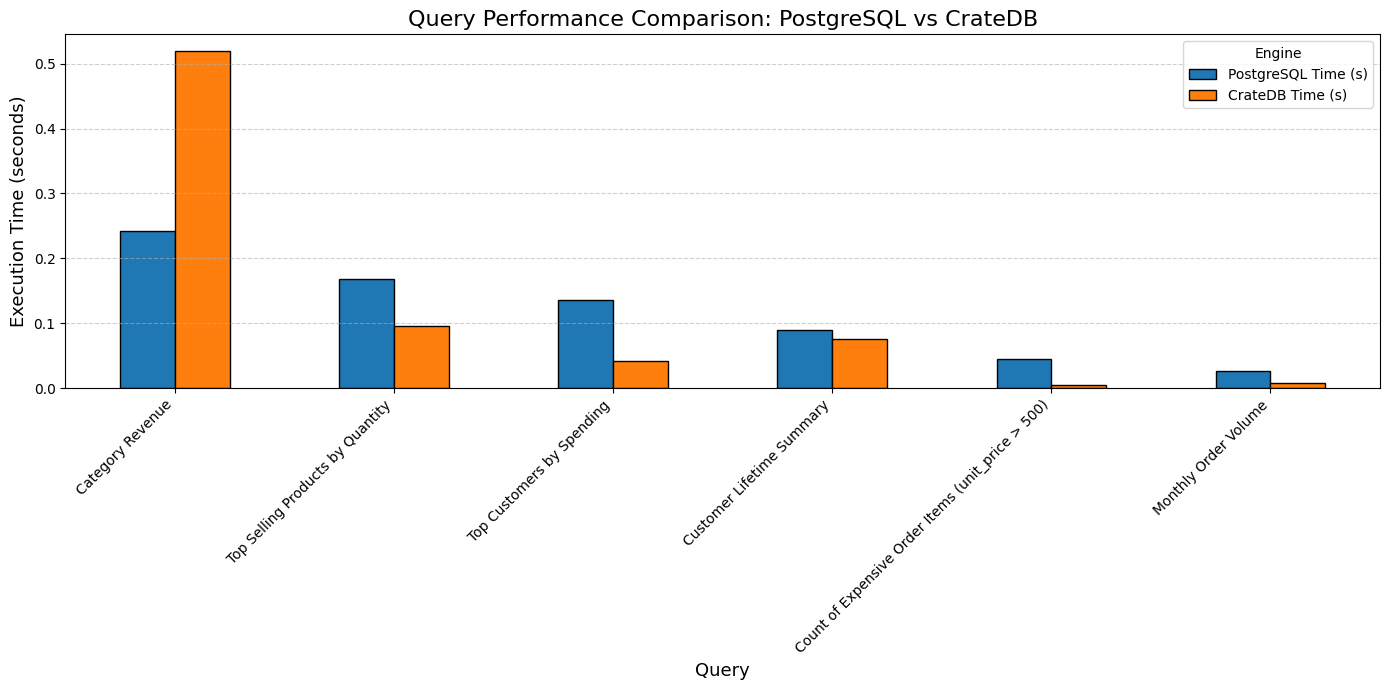

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert results to DataFrame
df = pd.DataFrame(results)

# Sort (optional)
df = df.sort_values(by='PostgreSQL Time (s)', ascending=False)

# Create larger figure size directly with the plot
ax = df.plot(
    x='Query',
    y=['PostgreSQL Time (s)', 'CrateDB Time (s)'],
    kind='bar',
    figsize=(14, 7),  # Increased size
    color=['#1f77b4', '#ff7f0e'],
    edgecolor='black'
)

# Titles and labels (removed emoji for compatibility)
plt.title("Query Performance Comparison: PostgreSQL vs CrateDB", fontsize=16)
plt.ylabel("Execution Time (seconds)", fontsize=13)
plt.xlabel("Query", fontsize=13)

# Improve appearance
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Engine", fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()
